In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import fastai
fastai.__version__

'1.0.28'

In [16]:
from fastai import *
from fastai_audio import *

from fastai.vision import models, ClassificationInterpretation

In [4]:
DATA = Path('data')
NSYNTH_AUDIO = DATA/'nsynth_audio' # contains train and valid folders

In [5]:
n_fft = 1024 # output of fft will have shape [513 x n_frames]
n_hop = 256  # 75% overlap between frames
n_mels = 40 # compress 513 dimensions to 40 on via mel frequency scale
sample_rate = 16000

tfms = get_frequency_batch_transforms(n_fft=n_fft, n_hop=n_hop,
                                      n_mels=n_mels, sample_rate=sample_rate)

In [6]:
batch_size = 64

instrument_family_pattern = r'(\w+)_\w+_\d+-\d+-\d+.wav$'

data = (AudioItemList
            .from_folder(NSYNTH_AUDIO)
            .filter_by_func(lambda fn: 'acoustic' in fn.name)
            .split_by_folder()
            .label_from_re(instrument_family_pattern)
            .databunch(bs=batch_size, tfms=tfms, equal_lengths=True))

In [7]:
data.c, data.classes

(10,
 ['mallet',
  'brass',
  'guitar',
  'keyboard',
  'vocal',
  'string',
  'reed',
  'flute',
  'organ',
  'bass'])

In [8]:
xs, ys = data.train_dl.one_batch()
xs.shape, ys.shape

(torch.Size([64, 1, 40, 251]), torch.Size([64]))

In [9]:
xs.min(), xs.max(), xs.mean(), xs.std()

(tensor(0.4587, device='cuda:0'),
 tensor(1., device='cuda:0'),
 tensor(0.5668, device='cuda:0'),
 tensor(0.0962, device='cuda:0'))

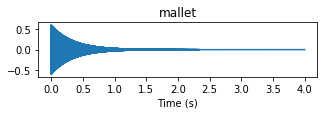

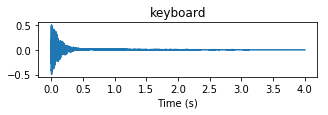

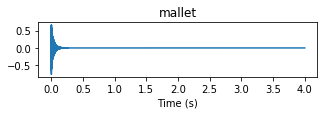

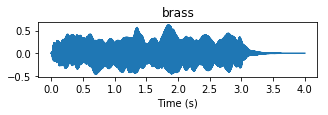

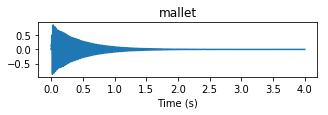

In [13]:
data.show_batch(5)

In [14]:
learn = create_cnn(data, models.resnet18, metrics=accuracy)
learn.fit_one_cycle(3)

Total time: 02:44
epoch  train_loss  valid_loss  accuracy
1      0.460028    0.961779    0.715457  (00:55)
2      0.263789    0.885294    0.778493  (00:54)
3      0.175693    0.830617    0.808353  (00:54)



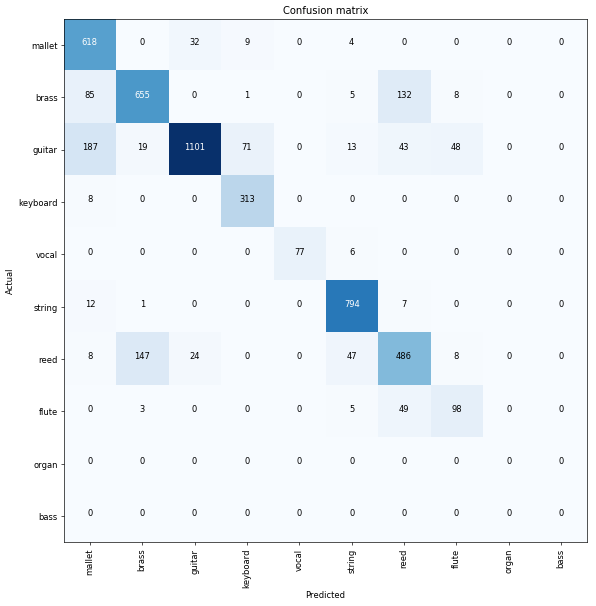

In [17]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(10, 10), dpi=60)

In [18]:
interp.most_confused(min_val=2)

[('guitar', 'mallet', 187),
 ('reed', 'brass', 147),
 ('brass', 'reed', 132),
 ('brass', 'mallet', 85),
 ('guitar', 'keyboard', 71),
 ('flute', 'reed', 49),
 ('guitar', 'flute', 48),
 ('reed', 'string', 47),
 ('guitar', 'reed', 43),
 ('mallet', 'guitar', 32),
 ('reed', 'guitar', 24),
 ('guitar', 'brass', 19),
 ('guitar', 'string', 13),
 ('string', 'mallet', 12),
 ('mallet', 'keyboard', 9),
 ('brass', 'flute', 8),
 ('keyboard', 'mallet', 8),
 ('reed', 'mallet', 8),
 ('reed', 'flute', 8),
 ('string', 'reed', 7),
 ('vocal', 'string', 6),
 ('brass', 'string', 5),
 ('flute', 'string', 5),
 ('mallet', 'string', 4),
 ('flute', 'brass', 3)]